# 🌲 Modelado TIER 1: Random Forest

> **Objetivo**: Entrenar y evaluar un modelo RandomForest para predecir **nombres de fertilizantes** basado en condiciones de suelo y cultivo.
> 
> **Variable Objetivo**: `Fertilizer Name` (nombres de fertilizantes codificados)
> 
> **Estrategia**: Usar RandomForest como modelo baseline debido a su robustez y facilidad de interpretación para problemas de clasificación multiclase.
> 
> **Métrica Principal**: MAP@3 (Mean Average Precision at 3) - requerida por la competencia de Kaggle

---

## 📚 1. Carga de Librerías y Datos

### Importación de librerías necesarias y carga de datos preprocesados

In [1]:
# Librerías principales
import pandas as pd
import numpy as np
import pickle
import joblib

# Utilidades del proyecto
import sys
sys.path.append('../src')
from model_utils import ModelTrainer, print_feature_selection_summary, print_training_config, show_prediction_examples
from visuals import plot_confusion_matrix, plot_probability_analysis, plot_predictions_vs_actual, plot_top3_accuracy_analysis, plot_feature_importance
from metrics import mapk

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Inicializar trainer y cargar datos
trainer = ModelTrainer('RandomForestClassifier', 'RFC')
data = trainer.load_data()

# Extraer datasets
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test = data['X_test']
feature_info = data['feature_info']
label_encoders = data['label_encoders']
fertilizer_encoder = label_encoders['Fertilizer Name']

print("Datos cargados exitosamente:")
print(f"  • Variable objetivo: {y_train.name}")

📂 Cargando datos preprocesados...
✅ Datos cargados: Train(600000, 32), Val(150000, 32), Test(250000, 32)
Datos cargados exitosamente:
  • Variable objetivo: Fertilizer Name_encoded


## 🎯 2. Selección de Features

### Definiendo las características que utilizaremos para el modelo

In [3]:
# =============================================================================
# SELECCIÓN DE FEATURES PARA EL MODELO
# =============================================================================

features_to_use = [
    # 🌡️ VARIABLES CLIMÁTICAS ORIGINALES
    'Temparature',
    'Humidity', 
    'Moisture',
    
    # 🌱 VARIABLES DE SUELO Y CULTIVO
    # 'Soil Type',
    # 'Crop Type',
    
    # 🧪 VARIABLES QUÍMICAS (NPK)
    'Nitrogen',
    'Potassium', 
    'Phosphorous',
    
    # # 📊 FEATURES ENGINEERED - RATIOS NPK
    # 'N_P_ratio',
    # 'N_K_ratio',
    # 'P_K_ratio',
    # 'Total_NPK',
    
    # # 🌡️ FEATURES ENGINEERED - ÍNDICES CLIMÁTICOS
    # 'Temp_Hum_index',
    # 'Moist_Balance',
    # 'Environ_Stress',
    
    # # 🏷️ FEATURES ENGINEERED - CATEGORÍAS
    # 'Temp_Cat',
    # 'Hum_Cat',
    # 'N_Level',
    # 'K_Level',
    # 'P_Level',
    
    # # 🔗 FEATURES ENGINEERED - COMBINACIONES
    # 'Soil_Crop_Combo',
    # 'NPK_Balance',
    # 'Dominant_NPK_Level',
    # 'Temp_Moist_inter',
    
    # # 🔢 FEATURES ENCODED (CATEGÓRICAS)
    'Soil Type_encoded',
    'Crop Type_encoded',
    # 'Temp_Cat_encoded',
    # 'Hum_Cat_encoded',
    # 'N_Level_encoded',
    # 'K_Level_encoded',
    # 'P_Level_encoded',
    # 'Soil_Crop_Combo_encoded'
]

# Validar features disponibles
features_to_use = trainer.validate_features(features_to_use, X_train)
print_feature_selection_summary(features_to_use, features_to_use)

✅ Features válidas: 8
🎯 FEATURES SELECCIONADAS: 8
   1. Temparature
   2. Humidity
   3. Moisture
   4. Nitrogen
   5. Potassium
   6. Phosphorous
   7. Soil Type_encoded
   8. Crop Type_encoded


## ⚙️ 3. Configuración de Hiperparámetros

### Definiendo los parámetros del modelo RandomForest

In [4]:
# =============================================================================
# CONFIGURACIÓN DE HIPERPARÁMETROS - BASELINE RÁPIDA
# =============================================================================

rf_params = {
    "n_estimators": 100,
    "max_depth": 20,
    "min_samples_split": 5,
    "min_samples_leaf": 4,
    "max_features": "log2",
    "bootstrap": True,
    "random_state": 513,
    "n_jobs": -1,
    "class_weight": "balanced",
    "oob_score": True,
    "criterion": "entropy", #"log_loss", #,"gini", 
}

print_training_config(rf_params)


⚙️ CONFIGURACIÓN:
  • n_estimators: 100
  • max_depth: 20
  • min_samples_split: 5
  • min_samples_leaf: 4
  • max_features: log2
  • bootstrap: True
  • random_state: 513
  • n_jobs: -1
  • class_weight: balanced
  • oob_score: True
  • criterion: entropy


## 🚀 4. Entrenamiento del Modelo

### Inicialización y entrenamiento del RandomForest

In [5]:
# =============================================================================
# ENTRENAMIENTO DEL MODELO
# =============================================================================

# Inicializar y entrenar modelo
rf_model = RandomForestClassifier(**rf_params)
rf_model = trainer.train_model(rf_model, X_train, y_train, features_to_use)

🚀 Entrenando RandomForestClassifier...
✅ Entrenamiento completado en 162.94s


## 📊 5. Evaluación del Modelo

### Evaluación del rendimiento en el conjunto de validación

In [6]:
# =============================================================================
# EVALUACIÓN DEL MODELO
# =============================================================================

# Evaluar modelo
metrics = trainer.evaluate_model(X_val, y_val, features_to_use)

# Generar predicciones para visualizaciones
y_pred_val = rf_model.predict(X_val[features_to_use])
y_pred_proba_val = rf_model.predict_proba(X_val[features_to_use])
classes = rf_model.classes_
y_pred_top3 = trainer.get_top3_predictions(y_pred_proba_val, classes)

# Mostrar ejemplos de predicciones
# show_prediction_examples(y_val, y_pred_top3, fertilizer_encoder, num_examples=3)

# Variables para visualizaciones
map3_score = metrics['map3_score']
auc_roc = metrics['auc_roc']
accuracy = metrics['accuracy']
precision = metrics['precision']
recall = metrics['recall']
f1 = metrics['f1_score']

📊 Evaluando modelo...
🎯 MAP@3: 0.3016 | AUC-ROC: 0.5437 | Accuracy: 0.1722


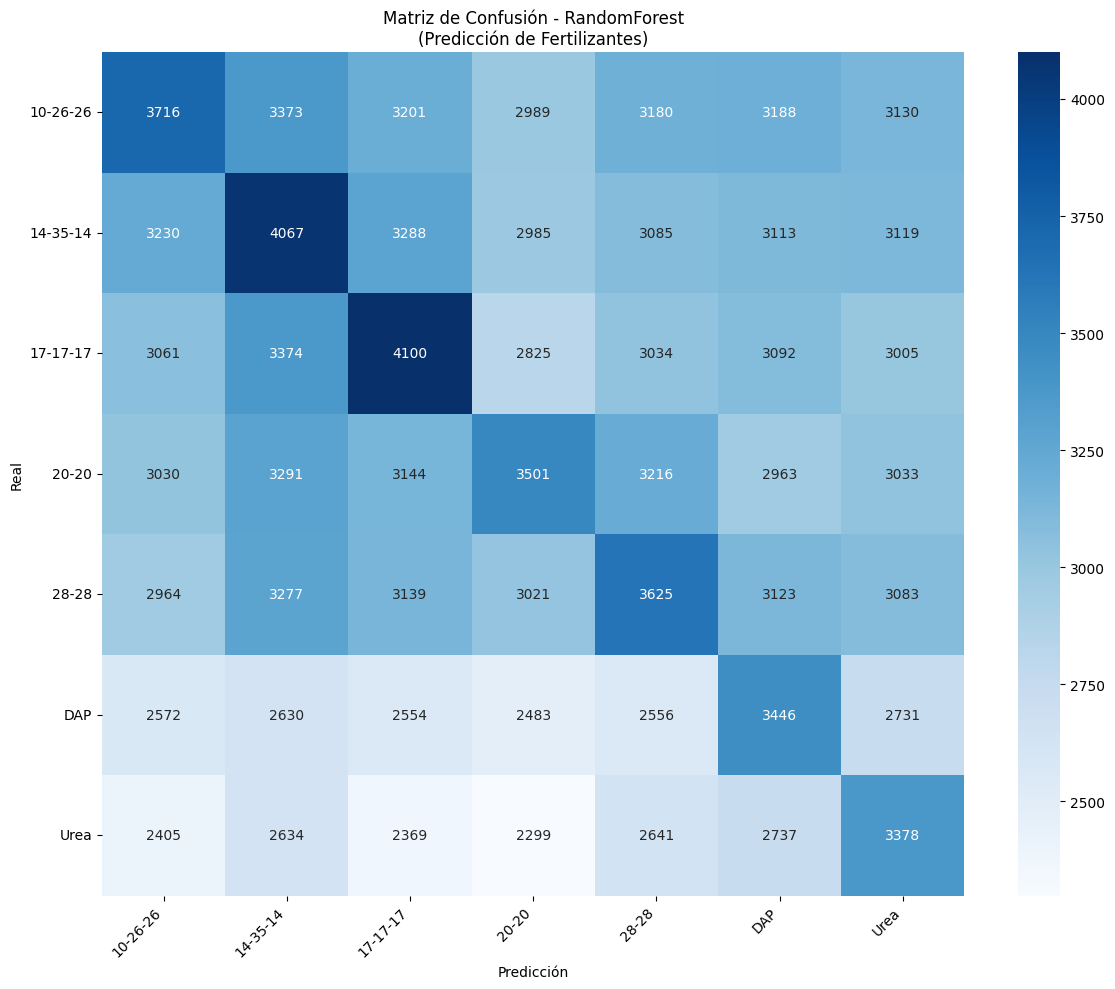

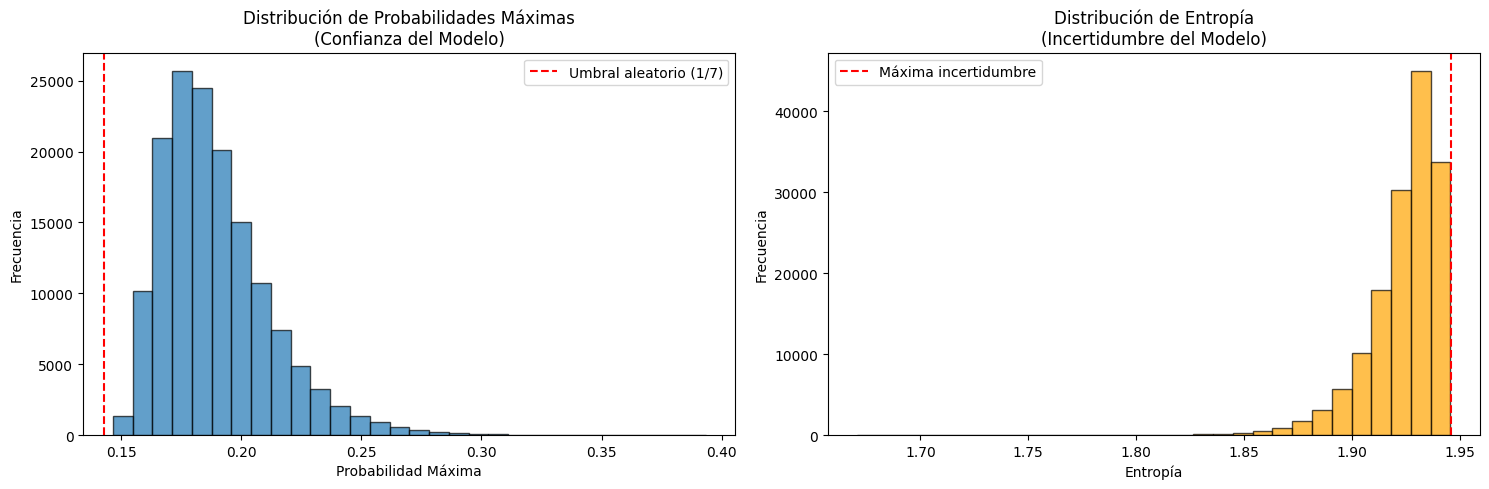

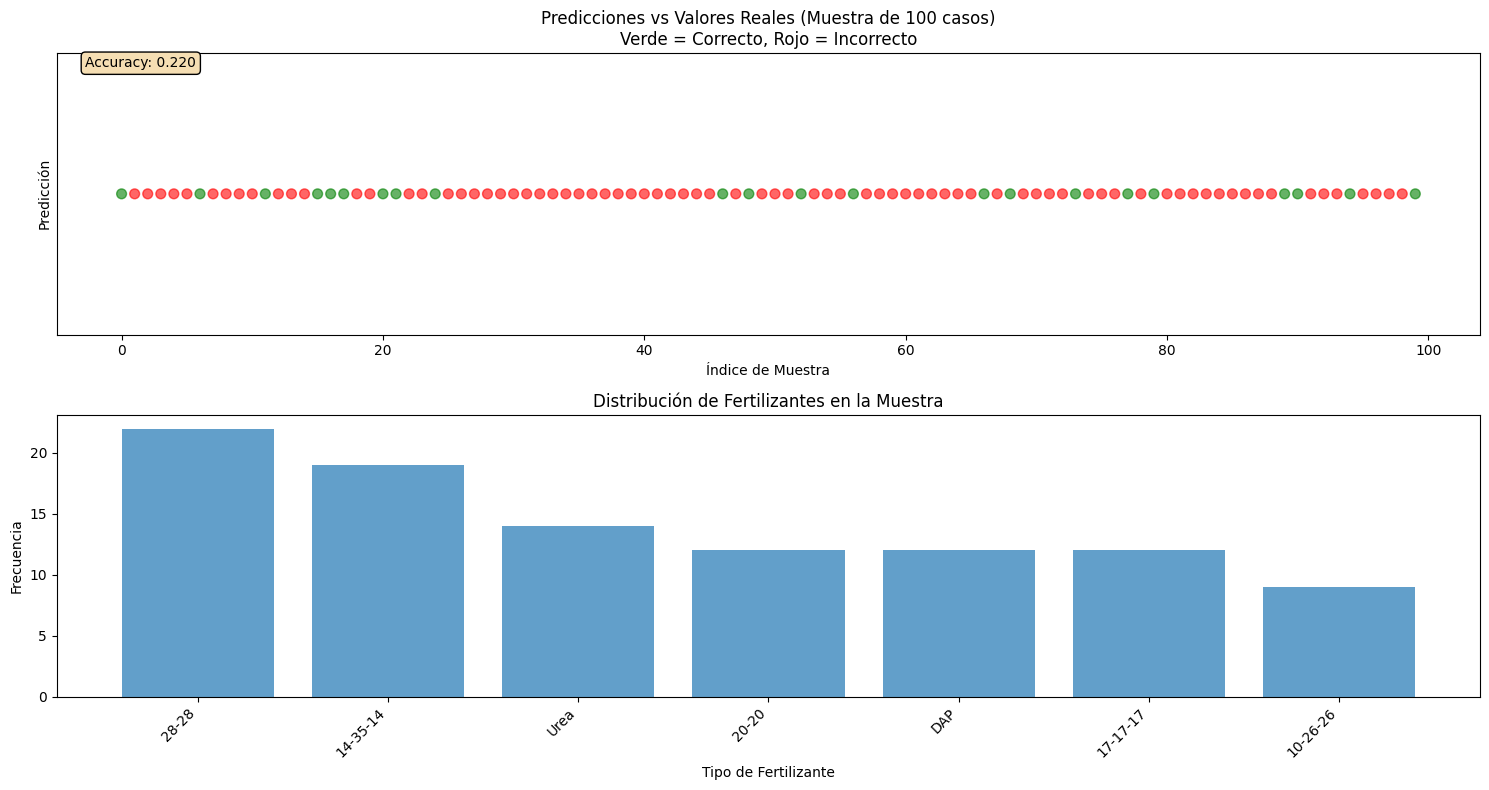

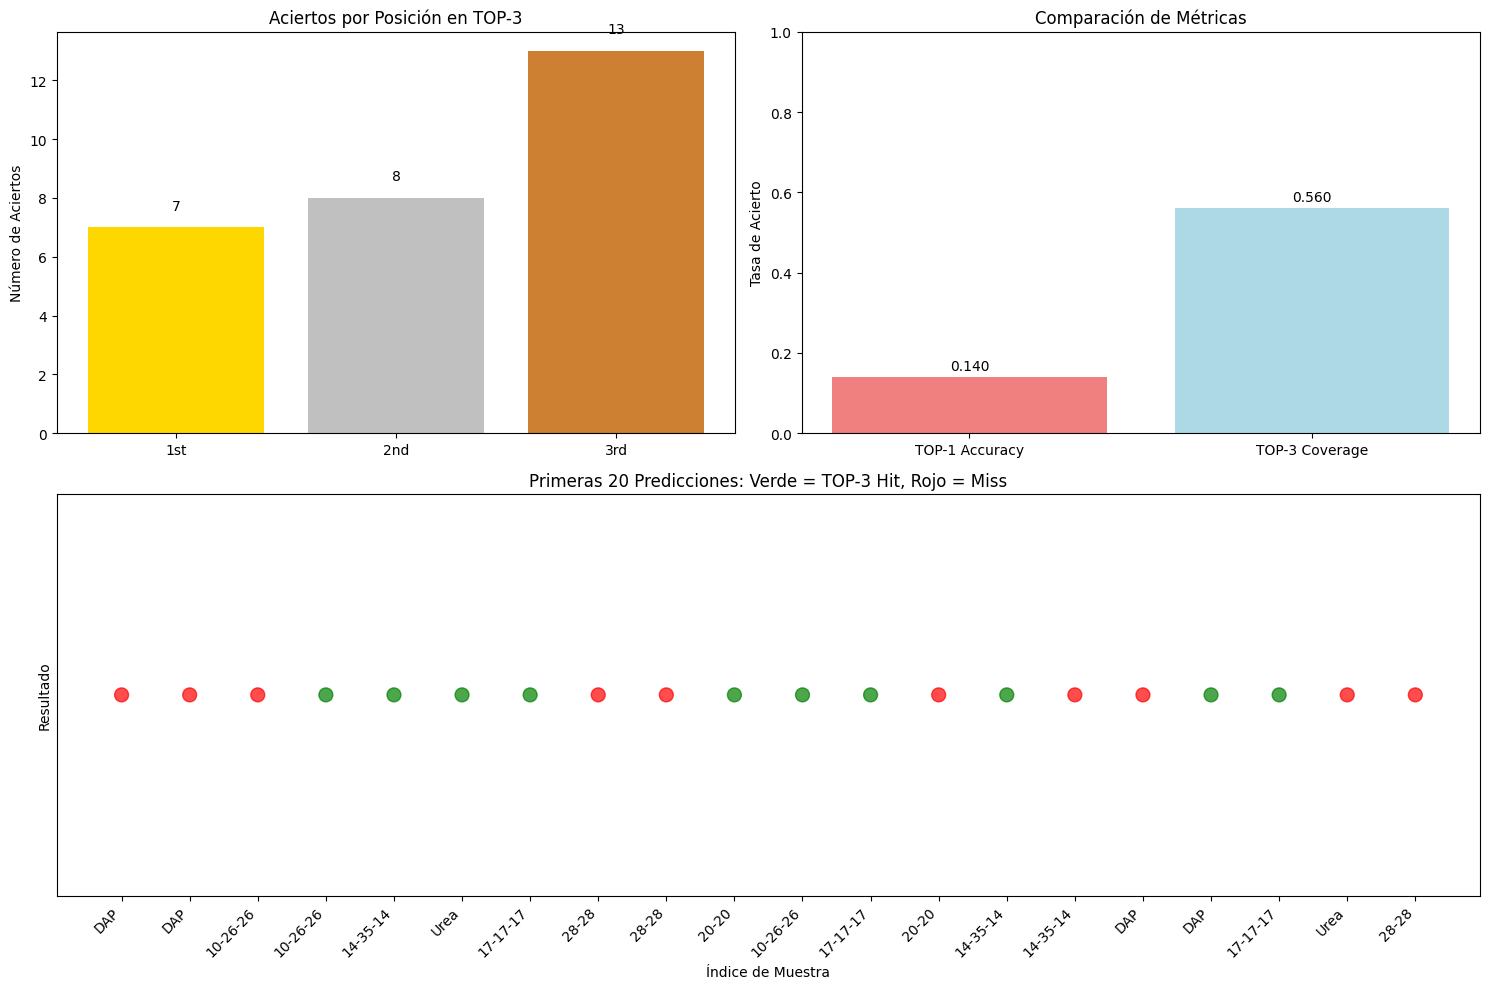


📊 Resumen TOP-3 Analysis:
  • Total samples: 50
  • TOP-3 Coverage: 0.560 (28/50)
  • Position 1 hits: 7 (0.140)
  • Position 2 hits: 8 (0.160)
  • Position 3 hits: 13 (0.260)
✅ Visualizaciones generadas correctamente


In [7]:
# =============================================================================
# VISUALIZACIONES DETALLADAS
# =============================================================================

# Importar funciones de visualización
import sys
sys.path.append('../src')
from visuals import (
    plot_confusion_matrix, 
    plot_probability_analysis, 
    plot_predictions_vs_actual,
    plot_top3_accuracy_analysis,
    plot_feature_importance
)

# 1. Matriz de confusión
fertilizer_names = [fertilizer_encoder.inverse_transform([c])[0] for c in classes]
plot_confusion_matrix(y_val, y_pred_val, fertilizer_names, "Matriz de Confusión - RandomForest")

# 2. Análisis de probabilidades
plot_probability_analysis(y_pred_proba_val, classes)

# 3. Comparación predicciones vs valores reales
comparison_df = plot_predictions_vs_actual(y_val, y_pred_val, fertilizer_encoder, sample_size=100)

# 4. Análisis detallado de TOP-3
top3_analysis = plot_top3_accuracy_analysis(y_val, y_pred_top3, fertilizer_encoder, sample_size=50)

print("✅ Visualizaciones generadas correctamente")

## 💾 6. Guardado del Modelo y Métricas

### Guardado del modelo entrenado y exportación de resultados

💾 Guardando artefactos en: RFC_MAP@3-03016/
✅ Artefactos guardados en carpeta: RFC_MAP@3-03016/
🏆 TOP 10 FEATURES MÁS IMPORTANTES:
 1. Nitrogen                       0.1696
 2. Phosphorous                    0.1663
 3. Humidity                       0.1504
 4. Moisture                       0.1461
 5. Temparature                    0.1314
 6. Potassium                      0.1257
 7. Crop Type_encoded              0.0613
 8. Soil Type_encoded              0.0493


d:\gh\kaggle\kaggle-playground-series-s5e6\notebooks\../src\visuals.py:247: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_features, x='importance', y='feature', ax=ax1, palette='viridis')
d:\gh\kaggle\kaggle-playground-series-s5e6\notebooks\../src\visuals.py:261: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\gh\kaggle\kaggle-playground-series-s5e6\notebooks\../src\visuals.py:261: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Felix\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Felix\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:

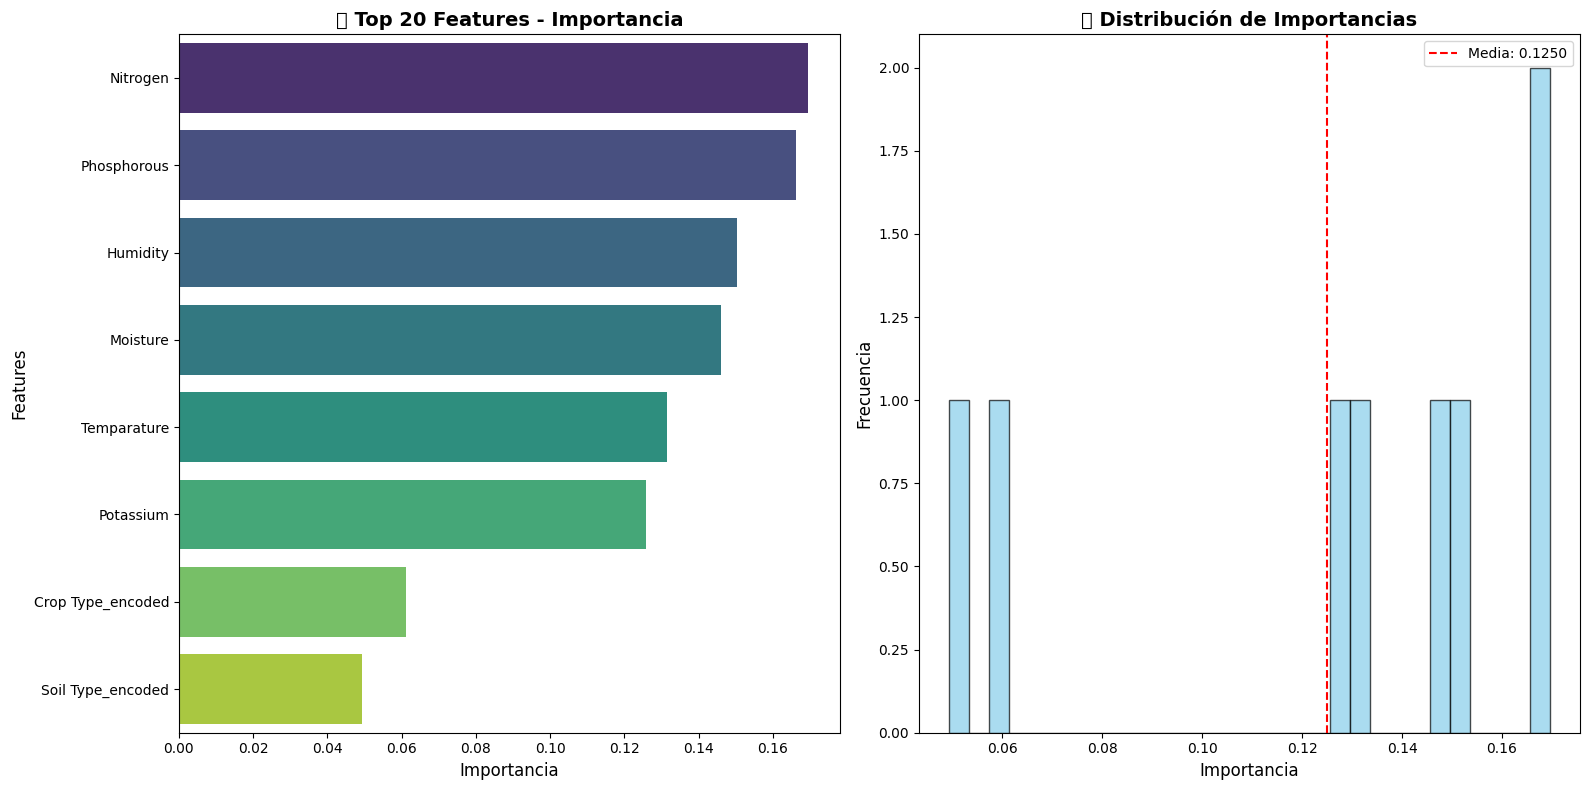


📈 Estadísticas de importancia:
  • Feature más importante: Nitrogen (0.1696)
  • Importancia promedio: 0.1250
  • Importancia mediana: 0.1387
  • Features con importancia > promedio: 6
🔍 Feature importance: RFC_MAP@3-03016_feature_importance.csv

🎉 RESUMEN - RandomForestClassifier
🎯 MAP@3: 0.3016
📊 AUC-ROC: 0.5437
🎯 Features: 8
⏱️ Tiempo: 162.94s


In [8]:
# =============================================================================
# GUARDADO DEL MODELO Y ARTEFACTOS
# =============================================================================

# Guardar todos los artefactos con nomenclatura estandarizada
base_filename = trainer.save_model_artifacts(
    model=rf_model,
    metrics=metrics, 
    hyperparams=rf_params,
    features=features_to_use
)

# Guardar feature importance
feature_importance_df = plot_feature_importance(
    feature_importances=rf_model.feature_importances_,
    feature_names=features_to_use,
    title="Importancia de Features - RandomForest TIER 1"
)

feature_importance_path = f'../models/{base_filename}/{base_filename}_feature_importance.csv'
feature_importance_df.to_csv(feature_importance_path, index=False)
print(f"🔍 Feature importance: {base_filename}_feature_importance.csv")

# Resumen final
trainer.print_summary(features_to_use)

## 📋 8. Generación de Submission (Opcional)

### Predicciones para el conjunto de test y creación del archivo de submission

In [9]:
# =============================================================================
# GENERACIÓN DE SUBMISSION PARA KAGGLE
# =============================================================================

# Generar submission usando el trainer
submission_df = trainer.generate_submission(
    X_test=X_test,
    features=features_to_use,
    label_encoder=fertilizer_encoder,
    base_filename=base_filename
)

# Mostrar muestra del submission
print(f"\n📋 SUBMISSION GENERADO:")
print(f"Formato: {list(submission_df.columns)} | Filas: {len(submission_df)}")


📤 Generando submission...
✅ Submission guardado en: RFC_MAP@3-03016/

📋 SUBMISSION GENERADO:
Formato: ['id', 'Fertilizer Name'] | Filas: 250000
